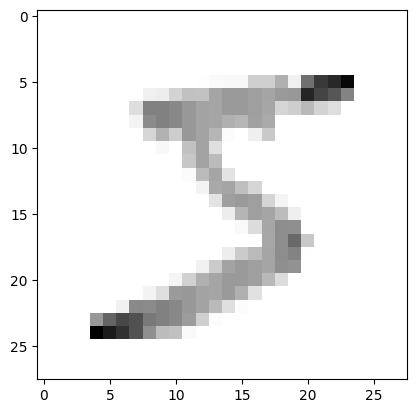

In [180]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Activation, Dropout

#get the mnist dataset from tensorflow keras
#About mnist: dataset containing a column of the label of the number,
#and the pictures of handwritten digits whcih are 28x28 pixels
mnist = tf.keras.datasets.mnist
#X contains the grids of pixels which make up the pics, y contains the labels
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#must scale down (normalize) the pixels' grayscale values (0-255) to a from 0 to 1 - just /255.0 in this case
#*Makes it easier for the nn to do the calculations
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)
#get a look at what the images look like
plt.imshow(X_train[0], cmap=plt.cm.binary)


In [181]:
# Resize image dimensions to make it suitable for filtering/pooling and convolutional operations

#add channel dimension=1 to the dimensions as for grayscale images there is only 1 channel of info (for RGB it would be 3)
X_trainr = np.array(X_train).reshape(60000, 28, 28, 1)
X_testr = np.array(X_test).reshape(10000, 28, 28, 1)

In [182]:
#Create Convolutional Neural Network

#Neural network model
model = tf.keras.models.Sequential()

#Add layers to the nn model:

#add first convolutional layer
model.add(Conv2D(64, (3,3), input_shape=X_trainr.shape[1:])) #dimension: 28x28x1 --> 26x26x64 (img_size - filter_size + stride = 28-3+1=26)
model.add(Activation("relu")) #use relu activation to ensure nonlinearity
model.add(MaxPooling2D(pool_size = (2,2))) #pool to accentuate presence of features, dimension: 26x26x64 -->13x13x64

model.add(Dropout(0.25))

#add 2nd convolutional layer
model.add(Conv2D(64, (3,3))) #dimension: 13x13x64 --> 11x11x64
model.add(Activation("relu")) #use relu activation to add nonlinearity
model.add(MaxPooling2D(pool_size = (2,2))) #pool to accentuate presence of features, dimension: 11x11x64 --> 5x5x64

model.add(Dropout(0.25))

#flatten the dimensions from 3D --> 1D to apply fully connected dense layers
model.add(Flatten())
        
#The dense layer uses the activation function relu (rectified linear unit) to condense them into 128 neurons
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))    
model.add(Dropout(0.5))
#last layer will have 10 neurons (representing 0-9), which will each store a number between 0 and 1.
#If u sum up all the numbers, they will add up to 1, and each number represents the confidence/probability
#of it being that digit.
model.add(Dense(10, activation="softmax"))

model.summary()


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,402 (982.04 KB)

 Trainable params: 251,402 (982.04 KB)

 Non-trainable params: 0 (0.00 B)

In [183]:
#compile model with adam optimizer, use categorical crossentropy to determine loss and measure accuracy
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

#to use categorical crossentropy as loss function, need to one-hot encode the labels
#ex 3 = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] --> more optimized comparison
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)

#fit the model with the data, run it over 3 times
history = model.fit(X_trainr, y_train_one_hot, epochs=3, validation_split=0.3)

model.save("digit_detector.keras")

loss, accuracy = model.evaluate(X_testr, y_test_one_hot)
print(loss)
print(accuracy)

Epoch 1/3
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.6704 - loss: 0.9703 - val_accuracy: 0.9689 - val_loss: 0.1069
Epoch 2/3
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9418 - loss: 0.2100 - val_accuracy: 0.9761 - val_loss: 0.0874
Epoch 3/3
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9622 - loss: 0.1525 - val_accuracy: 0.9822 - val_loss: 0.0649
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9823 - loss: 0.0602
0.0501047782599926
0.9851999878883362


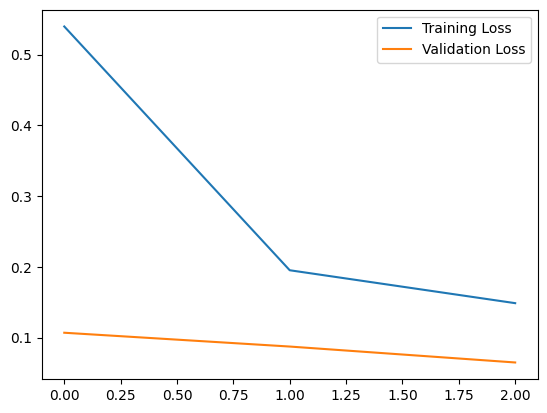

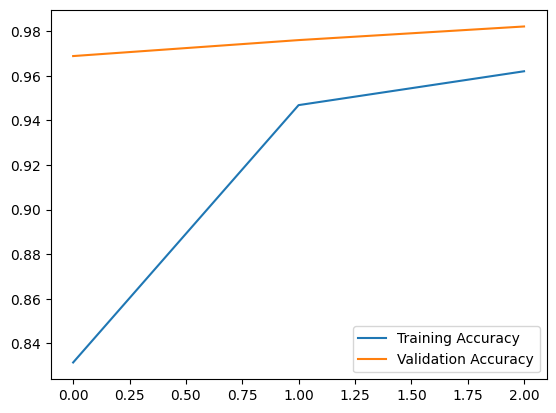

In [184]:
#plot training loss vs validation loss and training accuracy vs validation_accuracy to determine model overfitting:
#if validation loss starts to increase while training loss decreases --> overfitting
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

#if validation accuracy starts to stagnate/decrease while training accuracy increases --> overfitting
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()